In [4]:
import random
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# import esda
import libpysal.weights as weights
# from esda.moran import Moran
# from esda.moran import Moran_Local
from shapely.geometry import Point, MultiPoint, LineString, Polygon, shape
import json
import pylab
import networkx as nx
import libpysal
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

# from pyclustering.cluster import cluster_visualizer
# from pyclustering.cluster.birch import birch
# from pyclustering.cluster.cure import cure
# from pyclustering.cluster.dbscan import dbscan
# from pyclustering.cluster.kmeans import kmeans
# from pyclustering.cluster.optics import optics
# from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [2]:
def permutation(lst):
    if len(lst) == 0:
        return []

    if len(lst) == 1:
        return [lst]

    l = []
    for i in range(len(lst)):
        m = lst[i]
        remLst = lst[:i] + lst[i+1:]
        for p in permutation(remLst):
            l.append([m] + p)       
    return l

In [3]:
def get_f1_score(df, permut):
    def match_clus(x, permut):
        if x == 0:
            return int(permut[0])
        elif x == 1:
            return int(permut[1])
        elif x == 2:
            return int(permut[2])
        elif x == 3:
            return int(permut[3])
        elif x == 4:
            return int(permut[4])
        elif x == 5:
            return int(permut[5])
        elif x == 6:
            return int(permut[6])
        else:
            return x

    df["group_match"] = df["group"].apply(lambda x: match_clus(x, permut))
    return df, f1_score(df.group_match.values, df.clus_group_gt.values, average='macro')

In [4]:
def get_max_f1_score(df):
    max_f1 = 0
    max_p = []
    for p in permutation([1,2,3,4,5,6,7]):
        df, f1 = get_f1_score(df, p)
        if max_f1 < f1:
            max_f1 = f1
            max_p = p
    print("f1_score ", max_f1, max_p)

In [5]:
def cal_joint_statistic(synthetic_data_sticc, w_voronoi):
    matched_connects = 0
    all_neighbors_connects = 0
    for obj_id, neighbors in w_voronoi.neighbors.items():
        obj_clus = synthetic_data_sticc.iat[obj_id, -1]
        for nei in neighbors:
            nei_clus = synthetic_data_sticc.iat[nei, -1]
            all_neighbors_connects += 1
            if obj_clus == nei_clus:
                matched_connects += 1
    return matched_connects / all_neighbors_connects

# Ground Truth

In [13]:
synthetic_data = gpd.read_file('data/sticc_points.shp')
synthetic_data = synthetic_data.drop(["CID", "geometry"], axis=1)
synthetic_data["x"] = synthetic_data["x"] + 9965410
synthetic_data["y"] = synthetic_data["y"] - 5308400
synthetic_data["geometry"] = gpd.points_from_xy(x=synthetic_data.x, y=synthetic_data.y)
synthetic_data.head(1)

,clus_group,x,y,geometry
0,1,660.0,15060.0,POINT (660.000 15060.000)


In [14]:
def get_gt(x):
    if x == 8:
        return 3
    elif x == 4:
        return 1
    elif x == 9:
        return 4
    elif x == 10:
        return 2
    else:
        return x
    
synthetic_data["clus_group_gt"] = synthetic_data["clus_group"].apply(lambda x: get_gt(x))
synthetic_data.head(1)

,clus_group,x,y,geometry,clus_group_gt
0,1,660.0,15060.0,POINT (660.000 15060.000),1


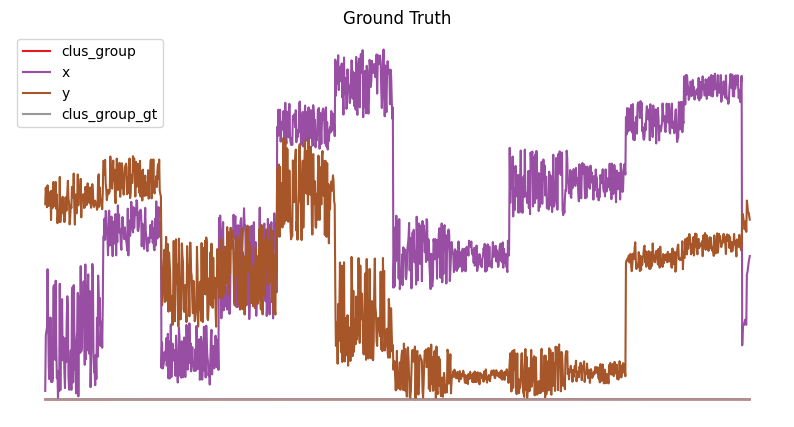

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
synthetic_data.plot(ax=ax, column="clus_group_gt", cmap="Set1", markersize=markersize, legend=True)
ax.set_axis_off()
ax.title.set_text('Ground Truth')

In [17]:
np.random.seed(1234)
def get_attr1(x):
    if x == 1:
        return np.random.normal(4, 1)
    elif x == 2:
        return np.random.normal(5, 1)
    elif x == 3:
        return np.random.normal(6, 1)
    elif x == 4:
        return np.random.normal(1, 1)
    elif x == 5:
        return np.random.normal(3, 1)
    elif x == 6:
        return np.random.normal(7, 1)
    elif x == 7:
        return np.random.normal(2, 1)
    
synthetic_data["attr1"] = synthetic_data["clus_group_gt"].apply(lambda x: get_attr1(x))

In [18]:
def get_attr2(x):
    if x == 1:
        return np.random.normal(1, 3)
    elif x == 2:
        return np.random.normal(7, 3)
    elif x == 3:
        return np.random.normal(2, 3)
    elif x == 4:
        return np.random.normal(3, 3)
    elif x == 5:
        return np.random.normal(6, 3)
    elif x == 6:
        return np.random.normal(4, 3)
    elif x == 7:
        return np.random.normal(5, 3)
    
synthetic_data["attr2"] = synthetic_data["clus_group_gt"].apply(lambda x: get_attr2(x))

In [19]:
def get_attr3(x):
    if x == 1:
        return np.random.normal(80, 20)
    elif x == 2:
        return np.random.normal(30, 20)
    elif x == 3:
        return np.random.normal(20, 20)
    elif x == 4:
        return np.random.normal(100, 20)
    elif x == 5:
        return np.random.normal(60, 20)
    elif x == 6:
        return np.random.normal(70, 20)
    elif x == 7:
        return np.random.normal(40, 20)
    
synthetic_data["attr3"] = synthetic_data["clus_group_gt"].apply(lambda x: get_attr3(x))

In [20]:
def get_attr4(x):
    if x == 1:
        return np.random.normal(1000, 350)
    elif x == 2:
        return np.random.normal(900, 350)
    elif x == 3:
        return np.random.normal(600, 350)
    elif x == 4:
        return np.random.normal(700, 350)
    elif x == 5:
        return np.random.normal(800, 350)
    elif x == 6:
        return np.random.normal(400, 350)
    elif x == 7:
        return np.random.normal(500, 350)
    
synthetic_data["attr4"] = synthetic_data["clus_group_gt"].apply(lambda x: get_attr4(x))

In [21]:
def get_attr5(x):
    if x == 1:
        return np.random.normal(999, 3)
    elif x == 2:
        return np.random.normal(992, 3)
    elif x == 3:
        return np.random.normal(1005, 3)
    elif x == 4:
        return np.random.normal(1003, 3)
    elif x == 5:
        return np.random.normal(999, 3)
    elif x == 6:
        return np.random.normal(998, 3)
    elif x == 7:
        return np.random.normal(1008, 3)
    
synthetic_data["attr5"] = synthetic_data["clus_group_gt"].apply(lambda x: get_attr5(x))

In [16]:
synthetic_data.head(1)

,clus_group,x,y,geometry,clus_group_gt
0,1,660.0,15060.0,POINT (660.000 15060.000),1


In [11]:
o = open("sticc-synthetic-data.txt", "w")

for i, r in synthetic_data.iterrows():
    o.write(str(r["attr1"]) + "," + str(r["attr2"]) + "," + str(r["attr3"]) + "," + str(r["attr4"]) + "," + str(r["attr5"]) + "\n")
    
o.close()

KeyError: 'attr1'

In [7]:
synthetic_data.clus_group

0       1
1       1
2       1
3       1
4       1
       ..
1208    1
1209    1
1210    1
1211    1
1212    4
Name: clus_group, Length: 1213, dtype: int64

In [9]:
o = open("sticc-synthetic-labels.txt", "w")

for i, r in synthetic_data.iterrows():
    o.write(str(r["clus_group"]) + "\n")
    
o.close()

In [210]:
pts_all = []
for pt in synthetic_data.iterrows():
    pts_all.append((pt[1].x, pt[1].y))
kd = libpysal.cg.KDTree(np.array(pts_all))
wnn = libpysal.weights.KNN(kd, 3)

/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  warnings.warn(message)


In [211]:
nearest_pt = pd.DataFrame().from_dict(wnn.neighbors, orient="index")
for i in range(nearest_pt.shape[1]):
    nearest_pt = nearest_pt.rename({i:f"n_pt_{i}"}, axis=1)
nearest_pt.head(1)

,n_pt_0,n_pt_1,n_pt_2
0,41,78,45


In [212]:
synthetic_data = synthetic_data.join(nearest_pt)
synthetic_data.head(1)

,clus_group,x,y,geometry,clus_group_gt,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
0,1,660.0,15060.0,POINT (660.000 15060.000),1,4.471435,2.15853,96.540978,1016.510958,997.32216,41,78,45


In [213]:
synthetic_data[["attr1", "attr2", 
                "attr3", 
                "attr4", "attr5", 
                "n_pt_0", "n_pt_1", "n_pt_2"
               ]].to_csv(r'synthetic_data.txt', header=None, index=True, sep=',')

In [214]:
synthetic_data_input = pd.read_table(r'synthetic_data.txt', sep=',', names=["id", "attr1", "attr2", 
                "attr3", 
                "attr4", "attr5", 
                "n_pt_0", "n_pt_1", "n_pt_2"
               ])
synthetic_data_input = synthetic_data_input.set_index("id")
synthetic_data_input.head(1)

,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
id,,,,,,,,
0,4.471435,2.15853,96.540978,1016.510958,997.32216,41,78,45


In [215]:
synthetic_data[["attr1", "attr2", 
                "attr3", "attr4", "attr5"]] = synthetic_data_input[["attr1", "attr2", 
                "attr3", "attr4", "attr5"]]
synthetic_data.head(1)

,clus_group,x,y,geometry,clus_group_gt,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
0,1,660.0,15060.0,POINT (660.000 15060.000),1,4.471435,2.15853,96.540978,1016.510958,997.32216,41,78,45


In [216]:
w_voronoi = weights.Voronoi.from_dataframe(synthetic_data)

/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:588: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


# STICC

In [145]:
def get_sticc_result(ground_truth, title='STICC', save_fig=False):
    sticc_group = pd.read_table('result_synthetic_data.txt', names=["group"])
    synthetic_data_sticc = ground_truth.join(sticc_group)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    markersize = 10
    synthetic_data_sticc.plot(column="group", cmap="Set1", markersize=markersize, legend=True, ax=ax)
    
    ax.set_axis_off()
    ax.title.set_text(title)
    if save_fig:
        fig.savefig('paper/exp1_result/sticc.jpg', dpi=300, bbox_inches='tight')

    print("ARI", adjusted_rand_score(synthetic_data_sticc.group, synthetic_data_sticc.clus_group_gt))
    
    sp_contiguity = cal_joint_statistic(synthetic_data_sticc, w_voronoi)
    print("Spatial contiguity: ", sp_contiguity)
    
    get_max_f1_score(synthetic_data_sticc)
    
    return synthetic_data_sticc

In [217]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 #--missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
Counter({5: 206, 1: 197, 4: 183, 3: 175, 0: 156, 2: 154, 6: 142})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 156
length of the cluster  1 ------> 197
length of the cluster  2 ------> 154
length of the cluster  3 ------> 175
length of the cluster  4 ------> 183
length of the cluster  5 ------> 206
length of the cluster  6 ------> 142
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[83.2425 96.0679 80.6077 ... 103.8976 103.9204 139.0877]
 [86.7712 117.8080 96.4345 ... 128.8488 139.3534 187.6393]
 [95.8098 118.4019 88.7908 ... 133.7677 121.4249 182.7817]
 ...
 [94.2420 98.4943 91.8166 ... 93.5377 87.

length of cluster # 0 --------> 200
length of cluster # 1 --------> 100
length of cluster # 2 --------> 402
length of cluster # 3 --------> 98
length of cluster # 4 --------> 200
length of cluster # 5 --------> 7
length of cluster # 6 --------> 206







ITERATION ### 7
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 200
length of the cluster  1 ------> 100
length of the cluster  2 ------> 402
length of the cluster  3 ------> 98
length of the cluster  4 ------> 200
length of the cluster  5 ------> 7
length of the cluster  6 ------> 206
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[143.7202 142.8919 81.3416 ... 119.5640 1875.4860 95.0526]
 [120.8667 141.6285 84.1986 ... 114.1418 5190.1537 107.2643]
 [150.7931 159.6000 86.7980 .

length of cluster # 0 --------> 200
length of cluster # 1 --------> 100
length of cluster # 2 --------> 403
length of cluster # 3 --------> 99
length of cluster # 4 --------> 200
length of cluster # 5 --------> 7
length of cluster # 6 --------> 204







ITERATION ### 14
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 200
length of the cluster  1 ------> 100
length of the cluster  2 ------> 403
length of the cluster  3 ------> 99
length of the cluster  4 ------> 200
length of the cluster  5 ------> 7
length of the cluster  6 ------> 204
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[143.7202 142.8919 81.2839 ... 119.5640 219.9494 94.9607]
 [120.8667 141.6285 84.0356 ... 114.1418 482.8255 106.9930]
 [150.7931 159.6000 86.6222 ..

In [ ]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data.txt --oname=result_synthetic_data_beta_0.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 #--missglasso

ARI 0.7713488414513452
Spatial contiguity:  0.8976717447542397
f1_score  0.7982781547524365 [2, 7, 1, 4, 3, 5, 6]


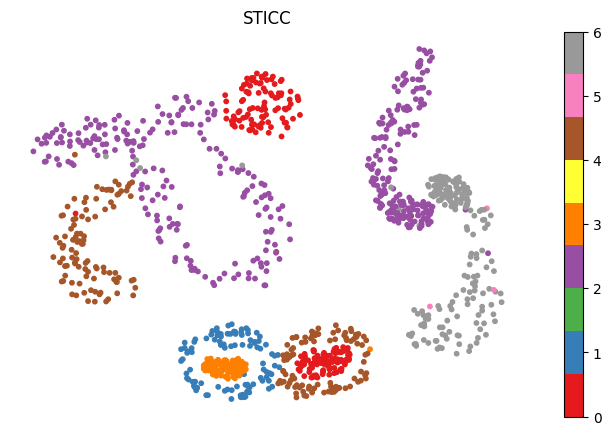

In [218]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [219]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({5: 206, 1: 197, 4: 183, 3: 175, 0: 156, 2: 154, 6: 142})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[132.4887 15

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[141.1149 152.2916 80.7096 ... 122.2947 129

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[141.1149 152.2916 80.7808 ... 131.1100 107.8300 97.2786]
 [123.6296 143.4

ARI 0.7355783253712989
Spatial contiguity:  0.8513940787582639
f1_score  0.7799107416787389 [2, 7, 1, 4, 3, 5, 6]


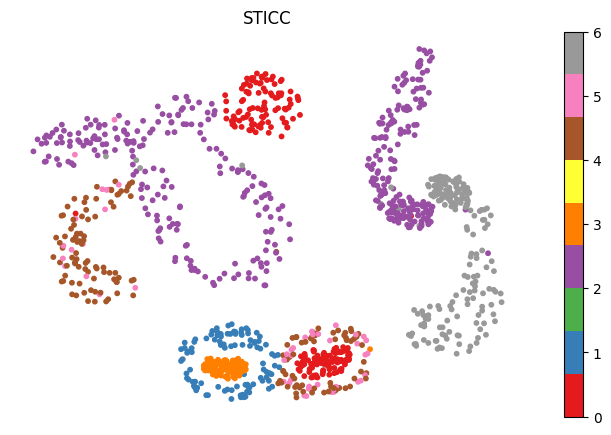

In [220]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

# MissSTICC

In [256]:
from utils import set_seed, create_random_mask, mean_imputation, compute_mse, plot_solution

complete_data = synthetic_data[["attr1", "attr2", "attr3", "attr4", "attr5", "n_pt_0", "n_pt_1", "n_pt_2"]]

complete_data.to_csv(r'synthetic_data_complete.txt', header=None, index=True, sep=',')

rate = 0.3

n, d = complete_data.shape
mask = create_random_mask(n, d, miss_percent=rate)
mask[:,5:] = True

missing_data = complete_data.copy()
missing_data[~mask] = np.nan

missing_data.to_csv(f'synthetic_data_missing_{rate}.txt', header=None, index=True, sep=',')

interp_data = complete_data.copy()
interp_data[~mask] = 0
mean_interp = np.mean(interp_data.values, axis=0, keepdims=True) * np.ones_like(interp_data)
mean_interp[mask] = 0
interp_data += mean_interp

interp_data.to_csv(f'synthetic_data_interp_{rate}.txt', header=None, index=True, sep=',')

In [275]:
missing_data.head(10)

,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
0,4.471435,2.158530,96.540978,1016.510958,997.322160,41,78,45
1,2.809024,NaN,68.550620,1701.553614,NaN,11,80,35
2,5.432707,-0.955757,104.233554,1050.562061,995.718074,55,96,50
3,3.687348,-3.462982,NaN,1155.213082,1003.505982,27,93,67
4,3.279411,5.550155,107.582494,NaN,1004.383387,69,82,81
5,NaN,NaN,120.998343,978.018249,NaN,89,37,75
6,4.859588,NaN,NaN,929.285334,1001.506516,68,8,36
7,3.363476,NaN,NaN,792.764108,997.473775,88,13,12
8,NaN,-0.797751,75.012122,1026.141121,997.927796,6,85,68
9,1.757315,NaN,NaN,614.177789,NaN,97,65,75


In [276]:
interp_data.head(10)

,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
0,4.471435,2.158530,96.540978,1016.510958,997.322160,41.0,78.0,45.0
1,2.809024,2.923008,68.550620,1701.553614,680.587743,11.0,80.0,35.0
2,5.432707,-0.955757,104.233554,1050.562061,995.718074,55.0,96.0,50.0
3,3.687348,-3.462982,38.360231,1155.213082,1003.505982,27.0,93.0,67.0
4,3.279411,5.550155,107.582494,529.191072,1004.383387,69.0,82.0,81.0
5,3.228786,2.923008,120.998343,978.018249,680.587743,89.0,37.0,75.0
6,4.859588,2.923008,38.360231,929.285334,1001.506516,68.0,8.0,36.0
7,3.363476,2.923008,38.360231,792.764108,997.473775,88.0,13.0,12.0
8,3.228786,-0.797751,75.012122,1026.141121,997.927796,6.0,85.0,68.0
9,1.757315,2.923008,38.360231,614.177789,680.587743,97.0,65.0,75.0


In [271]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_missing_0.2.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.05 --beta 3 --maxIters 20 --method missglasso

lam_sparse 0.05
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({1: 355, 2: 157, 3: 147, 6: 145, 4: 142, 5: 142, 0: 125})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 0.5046 95.3136 ... 102.1231 1160.1469 997.3036]
 [4.9204 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 86.4150 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 1000.5276]
 [4.2011 4.7917 96.0938 ... 75.1856 974.8752 1002.9541]]
[[4.4714 nan nan ... nan 1160.1469 997.3036]
 [nan 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... nan 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ..

(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[82.8406 114.7377 121.3870 ... 114.1360 116.7839 105.0889]
 [80.2057 162.6551 147.8403 ... 126.3205 121.5846 113.5091]
 [81.3441 151.8065 152.1859 ... 144.9409 138.7176 131.2182]
 ...
 [81.9142 109.3281 133.3222 ... 109.6683 109.6989 110.3751]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 224
length of cluster # 1 --------> 77
length of cluster # 2 --------> 100
length of cluster # 3 --------> 210
length of cluster # 4 --------> 194
length of cluster # 5 --------> 207
length of cluster # 6 --------> 201







ITERATION ### 5
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 0.9468 78.3192 ... 83.0309 1160.1469 997.3036]
 [5.2853 2.1455 68.5506 ... 91.5264

length of cluster # 0 --------> 208
length of cluster # 1 --------> 102
length of cluster # 2 --------> 100
length of cluster # 3 --------> 199
length of cluster # 4 --------> 203
length of cluster # 5 --------> 201
length of cluster # 6 --------> 200







ITERATION ### 10
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 1.5494 78.7866 ... 90.7830 1160.1469 997.3036]
 [4.5446 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 100.2025 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 999.2879]
 [4.2011 4.7917 96.0938 ... 75.1856 954.3351 1002.9541]]
[[4.4714 nan nan ... nan 1160.1469 997.3036]
 [nan 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... nan 1697.1719 1002.3078]
 ...
 [

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 1.5087 78.8161 ... 90.9382 1160.1469 997.3036]
 [4.5686 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 100.5022 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 999.2731]
 [4.2011 4.7917 96.0938 ... 75.1856 946.0954 1002.9541]]
[[4.4714 nan nan ... nan 1160.1469 997.3036]
 [nan 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... nan 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 nan]
 [4.2011 4.7917 96.0938 ... 75.1856 nan 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[76.7198 113.1195 179.2169 ... 112.8098 133

ARI 0.9547581981557769
Spatial contiguity:  0.89738430583501
f1_score  0.9816597528875828 [1, 4, 7, 5, 6, 3, 2]


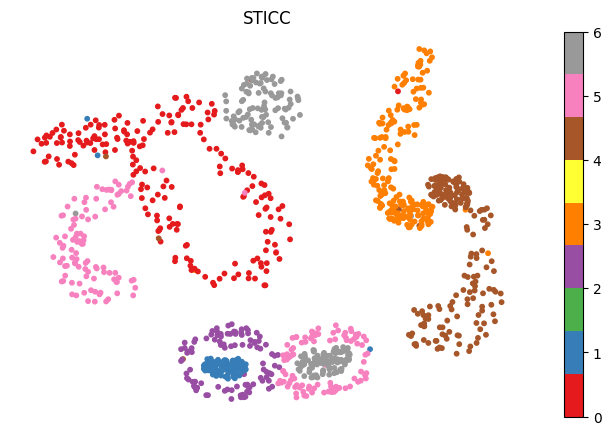

In [272]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [273]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_interp_0.2.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method glasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
Counter({6: 346, 0: 187, 4: 175, 2: 158, 3: 126, 1: 113, 5: 108})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 187
length of the cluster  1 ------> 113
length of the cluster  2 ------> 158
length of the cluster  3 ------> 126
length of the cluster  4 ------> 175
length of the cluster  5 ------> 108
length of the cluster  6 ------> 346
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[107.1626 113.3940 97.9660 ... 102.8989 140.9328 113.8162]
 [119.5972 209.6968 110.1513 ... 152.9812 156.3249 216.1161]
 [123.9350 167.9289 105.8154 ... 129.1357 149.9095 166.2696]
 ...
 [108.5736 125.5904 118.1513 ... 10

length of cluster # 0 --------> 125
length of cluster # 1 --------> 210
length of cluster # 2 --------> 292
length of cluster # 3 --------> 106
length of cluster # 4 --------> 90
length of cluster # 5 --------> 194
length of cluster # 6 --------> 196







ITERATION ### 7
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 125
length of the cluster  1 ------> 210
length of the cluster  2 ------> 292
length of the cluster  3 ------> 106
length of the cluster  4 ------> 90
length of the cluster  5 ------> 194
length of the cluster  6 ------> 196
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[113.5778 105.1829 97.6894 ... 108.6430 112.9928 105.7385]
 [126.6834 127.3257 107.8074 ... 132.1475 141.4338 125.9888]
 [133.2583 123.7977 105.6

length of cluster # 0 --------> 118
length of cluster # 1 --------> 197
length of cluster # 2 --------> 208
length of cluster # 3 --------> 107
length of cluster # 4 --------> 93
length of cluster # 5 --------> 201
length of cluster # 6 --------> 289







ITERATION ### 14
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 118
length of the cluster  1 ------> 197
length of the cluster  2 ------> 208
length of the cluster  3 ------> 107
length of the cluster  4 ------> 93
length of the cluster  5 ------> 201
length of the cluster  6 ------> 289
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[115.3013 108.2484 96.7059 ... 111.9249 113.8721 105.7334]
 [127.9198 133.7212 108.7788 ... 127.3656 141.2375 120.9413]
 [132.0978 128.0047 104.

ARI 0.7765010094512809
Spatial contiguity:  0.8192009198045416
f1_score  0.7586604423312269 [7, 6, 1, 4, 2, 3, 5]


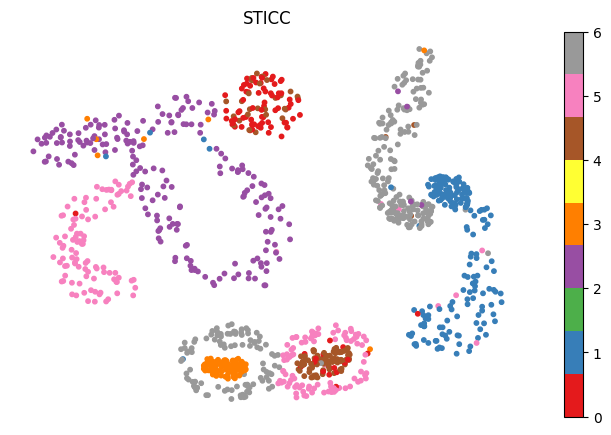

In [274]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [87]:
import collections
collections.Counter(synthetic_data["clus_group"])


synthetic_data

Counter({1: 113,
         2: 100,
         3: 99,
         4: 101,
         5: 197,
         6: 203,
         7: 100,
         9: 100,
         8: 100,
         10: 100})

In [180]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_complete.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({5: 206, 1: 197, 4: 183, 3: 175, 0: 156, 2: 154, 6: 142})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[132.4887 15

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[141.1149 152.2916 80.7096 ... 122.2947 129

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[141.1149 152.2916 80.7808 ... 131.1100 107.8300 97.2786]
 [123.6296 143.4

ARI 0.7355783253712989
Spatial contiguity:  0.8513940787582639
f1_score  0.7799107416787389 [2, 7, 1, 4, 3, 5, 6]


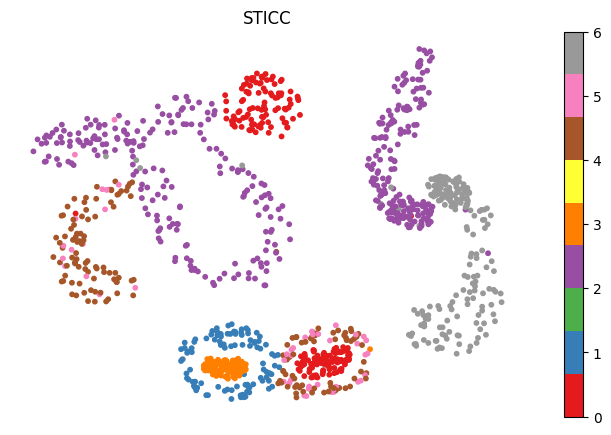

In [181]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

ARI 0.8727538090519678
Spatial contiguity:  0.77780971543547
f1_score  0.48084135092312724 [7, 2, 4, 3, 5, 6, 1]


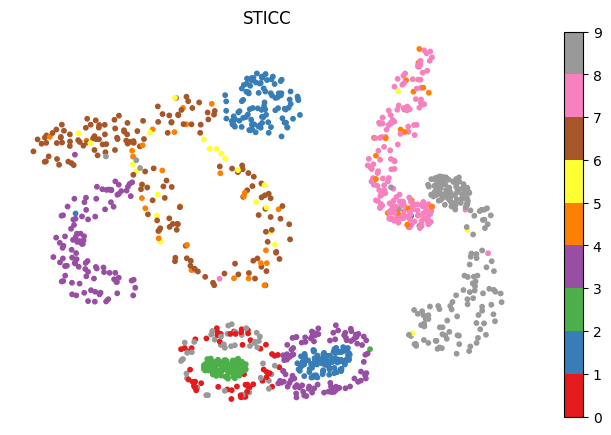

In [91]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [109]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_missing.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({5: 245, 0: 195, 6: 191, 4: 172, 2: 149, 1: 147, 3: 114})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 998.0637]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 nan]
 ...
 [5.4580 -2.466

Counter({6.0: 302, 2.0: 276, 4.0: 199, 0.0: 163, 5.0: 130, 3.0: 98, 1.0: 45})
beginning the smoothening ALGORITHM
[[108.2267 114.1771 113.1276 ... 92.5890 103.1082 78.8361]
 [113.0619 103.7386 119.9798 ... 88.1760 101.2581 85.5158]
 [120.7445 113.6967 122.9913 ... 98.6106 120.7934 81.1995]
 ...
 [97.2957 94.2287 100.7841 ... 90.8186 97.6606 83.3660]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 156
length of cluster # 1 --------> 44
length of cluster # 2 --------> 282
length of cluster # 3 --------> 118
length of cluster # 4 --------> 201
length of cluster # 5 --------> 127
length of cluster # 6 --------> 285







ITERATION ### 4
Start fitting MissGLasso Model
Start fitting MissGLasso Model
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.546e-04
  war

Counter({5: 245, 0: 195, 6: 191, 4: 172, 2: 149, 1: 147, 3: 114})
Counter({6: 222, 1: 201, 5: 177, 2: 172, 4: 159, 3: 148, 0: 134})
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[128.8211 135.6654 106.0089 ... 144.4872 111.1009 92.5591]
 [121.5699 124.1853 117.5949 ... 122.0521 115.1860 88.4154]
 [137.7226 141.3149 116.6750 ... 146.2467 131.5783 95.8187]
 ...
 [105.7601 109.8473 97.5524 ... 127.2362 118.9171 91.6294]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
Counter({3.0: 207, 6.0: 204, 2.0: 204, 4.0: 199, 1.0: 199, 0.0: 100, 5.0: 100})
beginning the smoothening ALGORITHM
[[126.4673 139.0766 109.0480 ... 143.7383 111.3380 93.3063]
 [121.5699 124.1853 117.5949 ... 122.0521 115.1860 88.4154]
 [137.3538 141.6117 117.0133 ... 146.7536 132.1231 96.0248]
 ...
 [105.7601 109.8473 97.5524 ... 127.2362 118.9171 91.6294]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0

ARI 0.9560151646120232
Spatial contiguity:  0.898246622592699
f1_score  0.9830393432780731 [7, 3, 6, 1, 2, 4, 5]


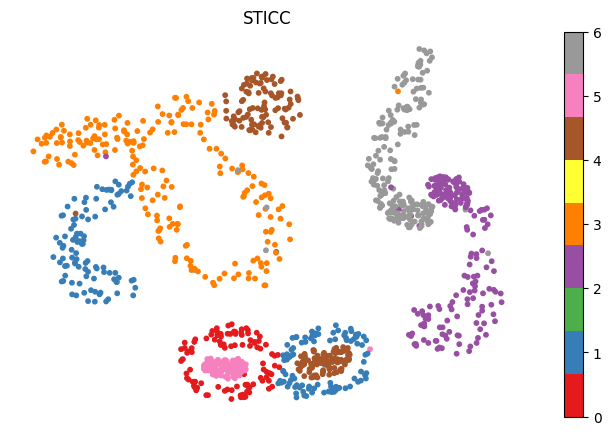

In [110]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [114]:
n, d = complete_data.shape
mask = create_random_mask(n, d, miss_percent=0.3)
mask[:,5:] = True

missing_data = complete_data.copy()
missing_data[~mask] = np.nan

missing_data.to_csv(r'synthetic_data_missing_03.txt', header=None, index=True, sep=',')

In [115]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_missing_03.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({2: 368, 3: 165, 0: 163, 4: 149, 5: 142, 6: 123, 1: 103})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 1.7453 96.5410 ... 95.4132 1160.1469 1000.4798]
 [2.8090 2.1455 78.6407 ... 85.9493 1682.9227 997.7790]
 [3.3544 2.4783 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [3.3073 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 1.7842 48.1142 ... 59.7766 912.2041 997.6658]
 [4.2011 4.7917 61.6735 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 nan 96.5410 ... 95.4132 1160.1469 nan]
 [2.8090 2.1455 nan ... nan 1682.9227 997.7790]
 [nan nan 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [nan -2.4663 59.7766 ... 79.345

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 1.0126 96.5410 ... 95.4132 1160.1469 998.0469]
 [2.8090 2.1455 87.6439 ... 92.1153 1682.9227 997.7790]
 [3.0987 -3.4528 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [3.8805 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 3.8896 48.1142 ... 59.7766 740.0747 998.5919]
 [4.2011 4.7917 80.1127 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 nan 96.5410 ... 95.4132 1160.1469 nan]
 [2.8090 2.1455 nan ... nan 1682.9227 997.7790]
 [nan nan 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [nan -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 nan 48.1142 ... 59.7766 nan nan]
 [4.2011 4.7917 nan ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[108.7711 135.6665 95.5187 ... 81.5589 74.4139 109.0522]
 [99.9737 137.0548 120.3747 ...

length of cluster # 0 --------> 193
length of cluster # 1 --------> 202
length of cluster # 2 --------> 100
length of cluster # 3 --------> 204
length of cluster # 4 --------> 351
length of cluster # 5 --------> 64
length of cluster # 6 --------> 99







ITERATION ### 10
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 1.0784 96.5410 ... 95.4132 1160.1469 1001.7709]
 [2.8090 2.1455 76.7937 ... 89.0866 1682.9227 997.7790]
 [4.4081 -2.2570 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [3.8950 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 3.8947 48.1142 ... 59.7766 771.3303 998.8892]
 [4.2011 4.7917 78.1364 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 nan 96.5410 ... 95.4132 1160.1469 nan]
 [2.8090 2.1455 nan ... nan 1682.9227 997.7790]
 [nan nan 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [nan -

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 0.3763 96.5410 ... 95.4132 1160.1469 1000.4423]
 [2.8090 2.1455 75.2136 ... 81.3486 1682.9227 997.7790]
 [4.2509 0.7402 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [3.7096 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 4.5025 48.1142 ... 59.7766 691.5522 999.5086]
 [4.2011 4.7917 70.3906 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 nan 96.5410 ... 95.4132 1160.1469 nan]
 [2.8090 2.1455 nan ... nan 1682.9227 997.7790]
 [nan nan 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [nan -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 nan 48.1142 ... 59.7766 nan nan]
 [4.2011 4.7917 nan ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[135.5830 163.3888 138.5885 ... 89.8787 74.2167 174.5491]

ARI 0.9544224305108948
Spatial contiguity:  0.899108939350388
f1_score  0.9819784415265095 [2, 3, 4, 6, 5, 1, 7]


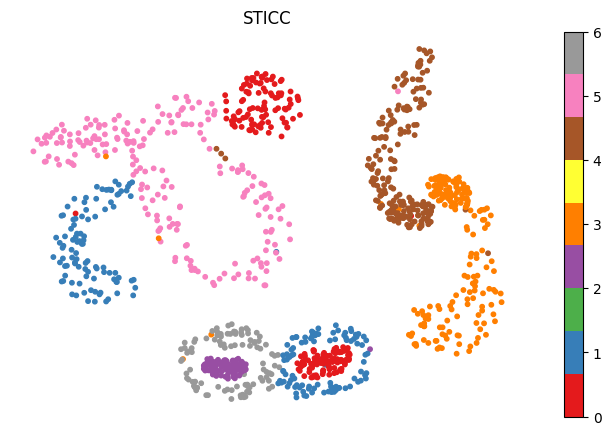

In [116]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [136]:
n, d = complete_data.shape
mask = create_random_mask(n, d, miss_percent=0.05)
mask[:,5:] = True

missing_data = complete_data.copy()
missing_data[~mask] = np.nan

missing_data.to_csv(r'synthetic_data_missing_005.txt', header=None, index=True, sep=',')

In [137]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_missing_005.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({5: 213, 3: 187, 1: 187, 0: 179, 6: 170, 4: 147, 2: 130})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [3.4749 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 82.6710 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 998.7282]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [nan -2.

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [3.9050 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 76.5091 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 999.2342]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [nan -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 nan ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 nan]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[126.4089 98.3174 121.8969

ARI 0.9517337020354224
Spatial contiguity:  0.8950847944811727
f1_score  0.9816592332241878 [2, 5, 3, 1, 6, 4, 7]


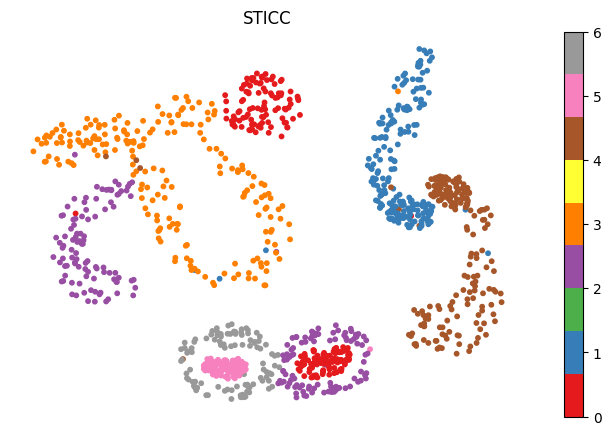

In [138]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [139]:
n, d = complete_data.shape
mask = create_random_mask(n, d, miss_percent=0.01)
mask[:,5:] = True

missing_data = complete_data.copy()
missing_data[~mask] = np.nan

missing_data.to_csv(r'synthetic_data_missing_001.txt', header=None, index=True, sep=',')

In [140]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_missing_001.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({3: 207, 1: 197, 0: 190, 6: 164, 5: 163, 2: 147, 4: 145})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[151.0783 10

/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.619e-04
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -1.356e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -1.274e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -1.126e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_grap

/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.516e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.714e-03
  warnings.warn(
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.550

(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[151.0783 108.6397 103.3542 ... 99.9822 141.7569 80.8083]
 [141.1653 112.1777 94.7967 ... 111.7149 124.6999 83.8378]
 [173.4026 112.6213 96.3620 ... 113.5209 153.3562 86.2513]
 ...
 [132.3078 105.3787 100.9115 ... 95.8647 126.1967 82.5839]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 100
length of cluster # 1 --------> 100
length of cluster # 2 --------> 36
length of cluster # 3 --------> 200
length of cluster # 4 --------> 173
length of cluster # 5 --------> 200
length of cluster # 6 --------> 404







ITERATION ### 18
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 16

ARI 0.7470447274077355
Spatial contiguity:  0.8582926128197758
f1_score  0.7869999967120951 [7, 4, 5, 3, 6, 2, 1]


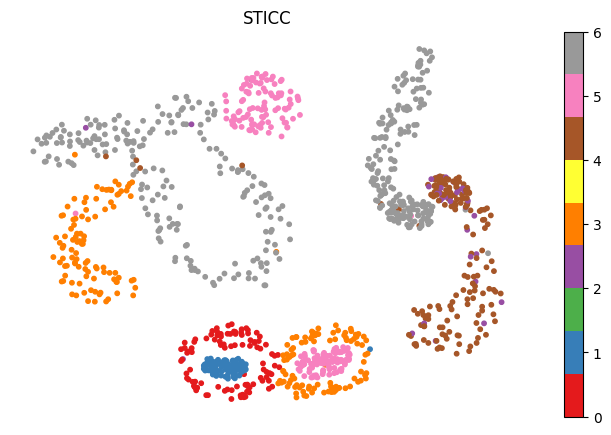

In [141]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [134]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_single.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({5: 206, 1: 197, 4: 183, 3: 175, 0: 156, 2: 154, 6: 142})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 -0.2811 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 nan 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -

length of cluster # 3 --------> 102
length of cluster # 4 --------> 169
length of cluster # 5 --------> 31
length of cluster # 6 --------> 206







ITERATION ### 5
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 0.1551 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 nan 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 6

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 0.1349 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 nan 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[144.1310 156.4

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 0.1349 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 nan 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[144.1310 156.4997 80.3565 ... 119.6926 160.7987 96.9322]
 [123.6296 143.4848

ARI 0.7216438778994053
Spatial contiguity:  0.8378844495544697
f1_score  0.7552413410386786 [2, 7, 1, 4, 3, 5, 6]


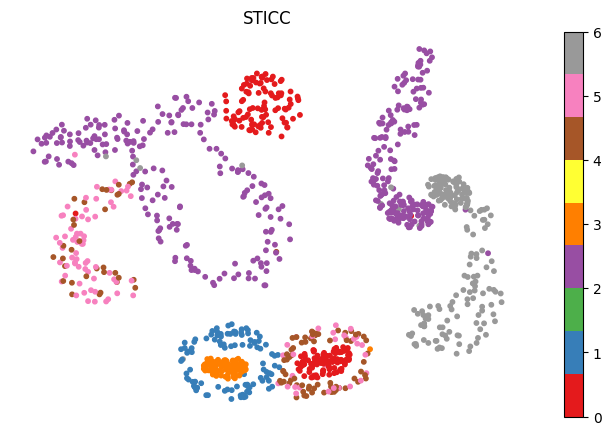

In [135]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [157]:
np.random.seed(1236)

n, d = complete_data.shape
mask = create_random_mask(n, d, miss_percent=0.2)
mask[:,5:] = True

missing_data = complete_data.copy()
missing_data[~mask] = np.nan

missing_data.to_csv(r'synthetic_data_missing_02.txt', header=None, index=True, sep=',')

In [158]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_missing_02.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({1: 309, 3: 183, 5: 179, 0: 163, 4: 131, 6: 125, 2: 123})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 0.8205 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 66.0427 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 87.2520 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 83.9432 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 68.3722 ... 62.7341 991.1968 997.9847]
 [4.2011 4.7917 72.6410 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 nan 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... nan 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... nan 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 nan 

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 1.7310 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 83.1977 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 96.5147 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 84.7546 ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 78.1951 ... 80.0639 979.3214 997.9847]
 [4.2011 4.7917 87.9965 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 nan 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... nan 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... nan 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 nan ... 79.3458 548.6657 1000.7949]
 [3.8393 -0.1025 nan ... nan nan 997.9847]
 [4.2011 4.7917 nan ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[131.7529 114.8312 78.0974 ... 122.1662 83.720

(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[140.1725 130.8227 84.7074 ... 108.3707 80.1999 131.5769]
 [119.0639 131.3728 89.2734 ... 119.8830 82.2076 121.9302]
 [153.9861 124.7256 81.0662 ... 119.4938 90.0819 123.6853]
 ...
 [143.7428 110.2323 75.8055 ... 106.4476 77.8250 116.8768]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 200
length of cluster # 1 --------> 100
length of cluster # 2 --------> 142
length of cluster # 3 --------> 100
length of cluster # 4 --------> 201
length of cluster # 5 --------> 271
length of cluster # 6 --------> 199







ITERATION ### 11
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 0.8546 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 90.0434 1

length of cluster # 0 --------> 200
length of cluster # 1 --------> 100
length of cluster # 2 --------> 214
length of cluster # 3 --------> 100
length of cluster # 4 --------> 201
length of cluster # 5 --------> 199
length of cluster # 6 --------> 199








CONVERGED!!! BREAKING EARLY!!!
[2.0000 2.0000 2.0000 ... 2.0000 2.0000 2.0000]


ARI 0.9685692722468506
Spatial contiguity:  0.9071572290888186
f1_score  0.9872285648501651 [2, 4, 1, 7, 6, 5, 3]


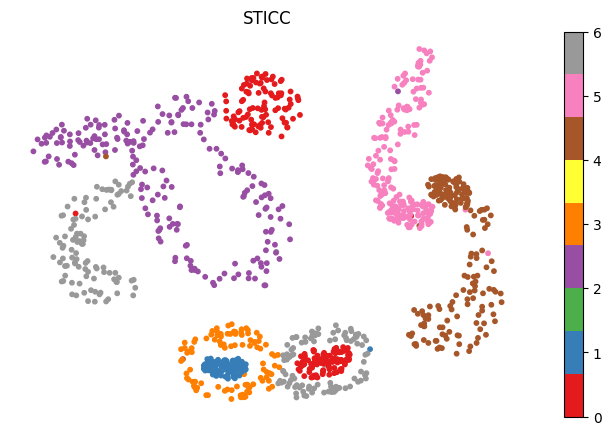

In [159]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [163]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_missing_02.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_once

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({1: 309, 3: 183, 5: 179, 0: 163, 4: 131, 6: 125, 2: 123})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 163
length of the cluster  1 ------> 309
length of the cluster  2 ------> 123
length of the cluster  3 ------> 183
length of the cluster  4 ------> 131
length of the cluster  5 ------> 179
length of the cluster  6 ------> 125
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[82.0657 94.3577 84.7717 ... 107.9467 78.3751 129.0632]
 [90.1674 148.5861 99.7205 ... 158.2145 99.7382 180.5272]
 [99.8011 133.5116 109.0030 ... 129.9120 88.7310 178.8

length of cluster # 0 --------> 117
length of cluster # 1 --------> 100
length of cluster # 2 --------> 85
length of cluster # 3 --------> 100
length of cluster # 4 --------> 201
length of cluster # 5 --------> 400
length of cluster # 6 --------> 210







ITERATION ### 7
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 117
length of the cluster  1 ------> 100
length of the cluster  2 ------> 85
length of the cluster  3 ------> 100
length of the cluster  4 ------> 201
length of the cluster  5 ------> 400
length of the cluster  6 ------> 210
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[139.4414 102.6928 105.1456 ... 106.5144 80.6789 93.1674]
 [106.4328 120.7559 94.0636 ... 107.6913 83.5449 97.9829]
 [145.6466 117.6679 122.4160 

length of cluster # 0 --------> 144
length of cluster # 1 --------> 100
length of cluster # 2 --------> 58
length of cluster # 3 --------> 100
length of cluster # 4 --------> 201
length of cluster # 5 --------> 400
length of cluster # 6 --------> 210







ITERATION ### 14
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 144
length of the cluster  1 ------> 100
length of the cluster  2 ------> 58
length of the cluster  3 ------> 100
length of the cluster  4 ------> 201
length of the cluster  5 ------> 400
length of the cluster  6 ------> 210
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[115.9475 102.6928 137.3205 ... 106.5144 80.6789 93.1674]
 [97.5445 120.7559 110.5269 ... 107.6913 83.5449 97.9829]
 [129.8974 117.6679 145.6953

ARI 0.717569018927686
Spatial contiguity:  0.838459327392929
f1_score  0.762946637769323 [2, 4, 5, 7, 3, 1, 6]


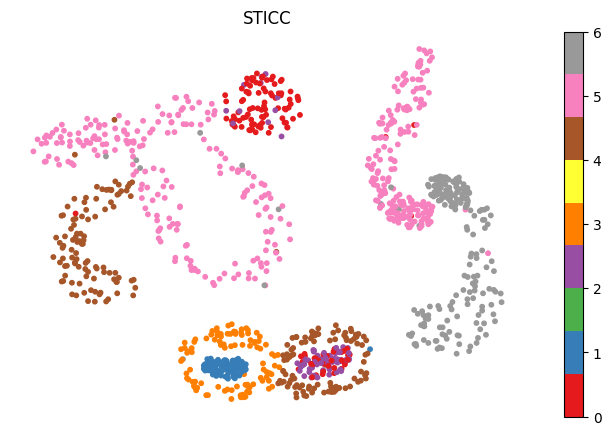

In [164]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [171]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_missing_001.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_once

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({3: 207, 1: 197, 0: 190, 6: 164, 5: 163, 2: 147, 4: 145})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 190
length of the cluster  1 ------> 197
length of the cluster  2 ------> 147
length of the cluster  3 ------> 207
length of the cluster  4 ------> 145
length of the cluster  5 ------> 163
length of the cluster  6 ------> 164
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[109.8931 85.2445 115.6336 ... 120.2819 84.6500 82.8367]
 [136.5701 96.5867 154.7615 ... 162.7802 92.4539 89.3922]
 [128.2455 108.9647 127.0205 ... 165.4743 90.4103 96.

length of cluster # 0 --------> 100
length of cluster # 1 --------> 100
length of cluster # 2 --------> 16
length of cluster # 3 --------> 195
length of cluster # 4 --------> 204
length of cluster # 5 --------> 387
length of cluster # 6 --------> 211







ITERATION ### 7
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 100
length of the cluster  1 ------> 100
length of the cluster  2 ------> 16
length of the cluster  3 ------> 195
length of the cluster  4 ------> 204
length of the cluster  5 ------> 387
length of the cluster  6 ------> 211
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[136.4765 101.8218 126.4048 ... 90.8404 81.8653 89.7694]
 [136.9001 108.6949 181.3778 ... 102.0847 83.8297 87.1212]
 [152.7989 111.2058 188.4356 

length of cluster # 0 --------> 100
length of cluster # 1 --------> 100
length of cluster # 2 --------> 15
length of cluster # 3 --------> 192
length of cluster # 4 --------> 206
length of cluster # 5 --------> 200
length of cluster # 6 --------> 400







ITERATION ### 14
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 100
length of the cluster  1 ------> 100
length of the cluster  2 ------> 15
length of the cluster  3 ------> 192
length of the cluster  4 ------> 206
length of the cluster  5 ------> 200
length of the cluster  6 ------> 400
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[136.4765 101.8218 100.9554 ... 95.2875 144.0917 81.5944]
 [136.9001 108.6949 116.1891 ... 107.3008 121.3148 84.0670]
 [152.7989 111.2058 90.846

ARI 0.7938180611199067
Spatial contiguity:  0.8378844495544697
f1_score  0.9006269139335049 [7, 4, 1, 3, 6, 2, 5]


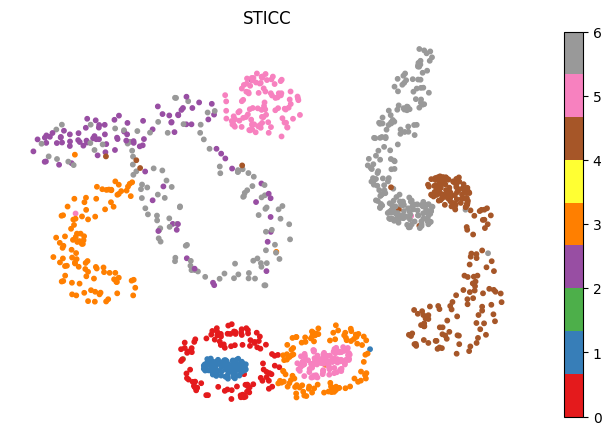

In [172]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

# Mean Interpolation

In [129]:
interp_data = complete_data.copy()
interp_data[~mask] = 0
mean_interp = np.mean(interp_data.values, axis=0, keepdims=True) * np.ones_like(interp_data)
mean_interp[mask] = 0
interp_data += mean_interp

interp_data.to_csv(r'synthetic_data_interp_03.txt', header=None, index=True, sep=',')

In [130]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_interp_03.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 #--missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
Counter({4: 327, 6: 230, 5: 194, 0: 161, 1: 107, 2: 102, 3: 92})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 161
length of the cluster  1 ------> 107
length of the cluster  2 ------> 102
length of the cluster  3 ------> 92
length of the cluster  4 ------> 327
length of the cluster  5 ------> 194
length of the cluster  6 ------> 230
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[107.2704 100.7899 161.9879 ... 145.0696 110.8713 123.9774]
 [113.2646 110.3480 221.3099 ... 249.0209 130.5531 202.6115]
 [115.3403 128.8600 194.5755 ... 197.4545 136.6895 164.8143]
 ...
 [111.7948 145.5783 123.0902 ... 106

length of cluster # 0 --------> 108
length of cluster # 1 --------> 202
length of cluster # 2 --------> 189
length of cluster # 3 --------> 242
length of cluster # 4 --------> 282
length of cluster # 5 --------> 130
length of cluster # 6 --------> 60







ITERATION ### 7
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 108
length of the cluster  1 ------> 202
length of the cluster  2 ------> 189
length of the cluster  3 ------> 242
length of the cluster  4 ------> 282
length of the cluster  5 ------> 130
length of the cluster  6 ------> 60
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[118.3138 100.7089 111.9849 ... 116.1124 139.2096 119.7771]
 [139.7528 107.4210 131.1518 ... 120.9469 122.4813 119.7630]
 [129.3378 116.1576 136.

length of cluster # 0 --------> 105
length of cluster # 1 --------> 216
length of cluster # 2 --------> 186
length of cluster # 3 --------> 220
length of cluster # 4 --------> 292
length of cluster # 5 --------> 158
length of cluster # 6 --------> 36







ITERATION ### 14
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 105
length of the cluster  1 ------> 216
length of the cluster  2 ------> 186
length of the cluster  3 ------> 220
length of the cluster  4 ------> 292
length of the cluster  5 ------> 158
length of the cluster  6 ------> 36
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[119.9132 101.2927 113.5401 ... 118.4404 130.0444 158.1197]
 [151.0063 107.5378 133.9877 ... 118.9872 121.4947 150.0237]
 [137.9437 116.6953 137

In [162]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

FileNotFoundError: [Errno 2] No such file or directory: 'result_synthetic_data.txt'

In [165]:
interp_data = complete_data.copy()
interp_data[~mask] = 0
mean_interp = np.mean(interp_data.values, axis=0, keepdims=True) * np.ones_like(interp_data)
mean_interp[mask] = 0
interp_data += mean_interp

interp_data.to_csv(r'synthetic_data_interp_02.txt', header=None, index=True, sep=',')

In [166]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_interp_02.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 #--missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
Counter({4: 275, 2: 232, 1: 180, 3: 168, 5: 123, 0: 121, 6: 114})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 121
length of the cluster  1 ------> 180
length of the cluster  2 ------> 232
length of the cluster  3 ------> 168
length of the cluster  4 ------> 275
length of the cluster  5 ------> 123
length of the cluster  6 ------> 114
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[135.5327 104.2280 113.1036 ... 119.9025 143.5546 98.2946]
 [201.7194 113.6775 176.7354 ... 197.3412 209.3605 118.7713]
 [162.4366 122.5150 159.5944 ... 159.9308 211.1579 113.5838]
 ...
 [111.0128 106.9758 96.7382 ... 106

length of cluster # 0 --------> 140
length of cluster # 1 --------> 193
length of cluster # 2 --------> 65
length of cluster # 3 --------> 286
length of cluster # 4 --------> 113
length of cluster # 5 --------> 207
length of cluster # 6 --------> 209







ITERATION ### 7
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 140
length of the cluster  1 ------> 193
length of the cluster  2 ------> 65
length of the cluster  3 ------> 286
length of the cluster  4 ------> 113
length of the cluster  5 ------> 207
length of the cluster  6 ------> 209
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[148.8629 122.7578 129.7304 ... 108.7614 116.6268 94.9575]
 [128.0125 120.4277 135.3824 ... 131.9067 127.3246 106.3688]
 [122.7613 127.0938 129.2

length of cluster # 0 --------> 192
length of cluster # 1 --------> 186
length of cluster # 2 --------> 26
length of cluster # 3 --------> 294
length of cluster # 4 --------> 112
length of cluster # 5 --------> 200
length of cluster # 6 --------> 203







ITERATION ### 14
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 192
length of the cluster  1 ------> 186
length of the cluster  2 ------> 26
length of the cluster  3 ------> 294
length of the cluster  4 ------> 112
length of the cluster  5 ------> 200
length of the cluster  6 ------> 203
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[134.6623 122.6393 146.0994 ... 108.5085 116.3948 94.7299]
 [126.1373 120.3223 194.2454 ... 132.2327 126.6161 106.1512]
 [122.1997 126.3393 163.

ARI 0.7663533493618431
Spatial contiguity:  0.7872951997700489
f1_score  0.7621926594598228 [3, 2, 7, 5, 4, 6, 1]


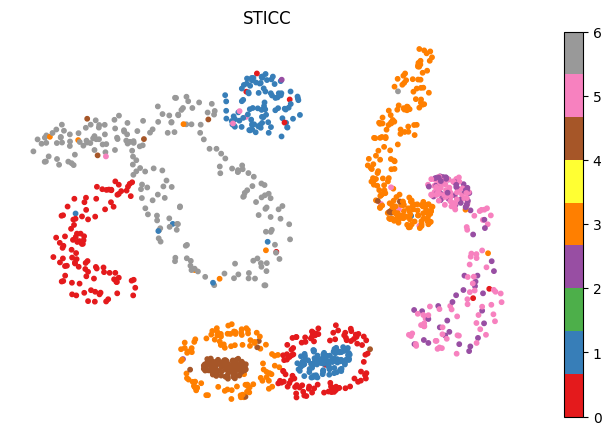

In [167]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [185]:
n, d = complete_data.shape
mask = create_random_mask(n, d, miss_percent=0.05)
mask[:,5:] = True

missing_data = complete_data.copy()
missing_data[~mask] = np.nan

missing_data.to_csv(r'synthetic_data_missing_005.txt', header=None, index=True, sep=',')

interp_data = complete_data.copy()
interp_data[~mask] = 0
mean_interp = np.mean(interp_data.values, axis=0, keepdims=True) * np.ones_like(interp_data)
mean_interp[mask] = 0
interp_data += mean_interp


interp_data.to_csv(r'synthetic_data_interp_005.txt', header=None, index=True, sep=',')

In [186]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_missing_005.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
(1213, 15)
Start fitting MissGLasso Model
(1213, 15)
Counter({4: 199, 6: 198, 1: 190, 0: 189, 5: 154, 3: 144, 2: 139})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [4.7736 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [4.3246 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [nan -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[118.0819 135.0

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [4.0263 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [nan -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[118.3599 163.5810 105.6714 ... 108.4316 129.6492 80.2203]
 [108.9277 147.015

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [4.0343 -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
[[4.4714 2.1585 96.5410 ... 95.4132 1160.1469 997.3036]
 [2.8090 2.1455 68.5506 ... 91.5264 1682.9227 997.7790]
 [5.4327 -0.9558 104.2336 ... 110.8653 1697.1719 1002.3078]
 ...
 [5.4580 -2.4663 59.7766 ... 79.3458 548.6657 1000.7949]
 [nan -0.1025 48.1142 ... 59.7766 655.5027 997.9847]
 [4.2011 4.7917 96.0938 ... 75.1856 1081.3655 1002.9541]]
Start fitting MissGLasso Model
(1213, 15)
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[118.4405 164.1773 106.2232 ... 108.5726 137.0883 80.2410]
 [108.9783 147.2539 114.3024 ... 108.1448 118.432

ARI 0.7578719757693508
Spatial contiguity:  0.8746766312158666
f1_score  0.7928008067107776 [3, 7, 6, 5, 4, 2, 1]


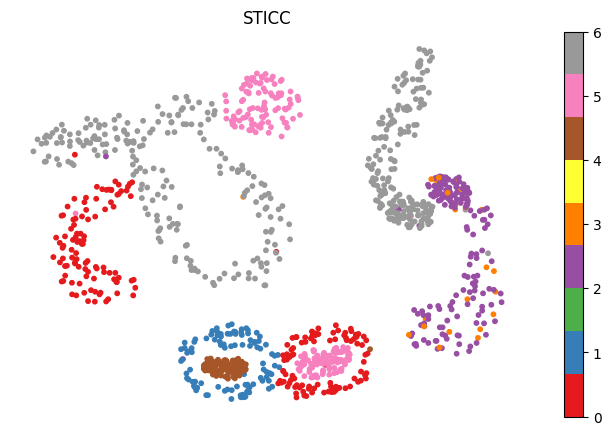

In [187]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [188]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data_interp_005.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 #--missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
Counter({0: 200, 1: 195, 2: 187, 5: 183, 3: 161, 6: 144, 4: 143})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 200
length of the cluster  1 ------> 195
length of the cluster  2 ------> 187
length of the cluster  3 ------> 161
length of the cluster  4 ------> 143
length of the cluster  5 ------> 183
length of the cluster  6 ------> 144
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[105.7491 115.5013 141.4954 ... 126.7326 104.6397 141.5380]
 [122.9096 156.8454 150.3188 ... 179.9810 137.6431 191.1434]
 [114.5933 137.1464 138.6961 ... 164.8150 113.4448 142.7232]
 ...
 [93.4682 85.4941 105.7344 ... 99.

length of cluster # 0 --------> 197
length of cluster # 1 --------> 100
length of cluster # 2 --------> 109
length of cluster # 3 --------> 191
length of cluster # 4 --------> 194
length of cluster # 5 --------> 231
length of cluster # 6 --------> 191







ITERATION ### 7
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 197
length of the cluster  1 ------> 100
length of the cluster  2 ------> 109
length of the cluster  3 ------> 191
length of the cluster  4 ------> 194
length of the cluster  5 ------> 231
length of the cluster  6 ------> 191
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[142.5522 124.0444 93.9716 ... 143.6507 110.6384 140.2353]
 [126.7641 131.7967 101.2356 ... 130.8392 108.4187 148.5903]
 [133.8255 116.2993 97.

length of cluster # 0 --------> 207
length of cluster # 1 --------> 100
length of cluster # 2 --------> 45
length of cluster # 3 --------> 193
length of cluster # 4 --------> 182
length of cluster # 5 --------> 294
length of cluster # 6 --------> 192







ITERATION ### 14
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 207
length of the cluster  1 ------> 100
length of the cluster  2 ------> 45
length of the cluster  3 ------> 193
length of the cluster  4 ------> 182
length of the cluster  5 ------> 294
length of the cluster  6 ------> 192
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[141.9764 124.0444 90.6599 ... 151.0452 105.0941 140.2796]
 [128.7878 131.7967 103.8855 ... 147.0538 107.6353 148.5815]
 [133.2917 116.2993 96.8

ARI 0.7832518777720165
Spatial contiguity:  0.8226501868352974
f1_score  0.7879288431058474 [2, 4, 7, 1, 6, 5, 3]


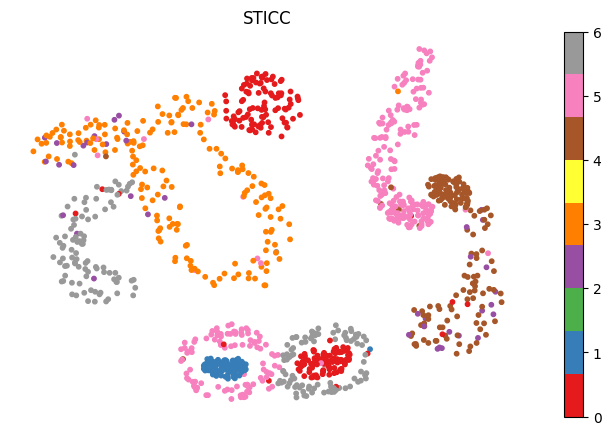

In [189]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [176]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 #--missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)
Counter({5: 206, 1: 197, 4: 183, 3: 175, 0: 156, 2: 154, 6: 142})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 156
length of the cluster  1 ------> 197
length of the cluster  2 ------> 154
length of the cluster  3 ------> 175
length of the cluster  4 ------> 183
length of the cluster  5 ------> 206
length of the cluster  6 ------> 142
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[83.2425 96.0679 80.6077 ... 103.8976 103.9204 139.0877]
 [86.7712 117.8080 96.4345 ... 128.8488 139.3534 187.6393]
 [95.8098 118.4019 88.7908 ... 133.7677 121.4249 182.7817]
 ...
 [94.2420 98.4943 91.8166 ... 93.5377 87.

length of cluster # 0 --------> 200
length of cluster # 1 --------> 100
length of cluster # 2 --------> 402
length of cluster # 3 --------> 98
length of cluster # 4 --------> 200
length of cluster # 5 --------> 7
length of cluster # 6 --------> 206







ITERATION ### 7
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 200
length of the cluster  1 ------> 100
length of the cluster  2 ------> 402
length of the cluster  3 ------> 98
length of the cluster  4 ------> 200
length of the cluster  5 ------> 7
length of the cluster  6 ------> 206
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[143.7202 142.8919 81.3416 ... 119.5640 1875.4860 95.0526]
 [120.8667 141.6285 84.1986 ... 114.1418 5190.1537 107.2643]
 [150.7931 159.6000 86.7980 .

length of cluster # 0 --------> 200
length of cluster # 1 --------> 100
length of cluster # 2 --------> 403
length of cluster # 3 --------> 99
length of cluster # 4 --------> 200
length of cluster # 5 --------> 7
length of cluster # 6 --------> 204







ITERATION ### 14
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 200
length of the cluster  1 ------> 100
length of the cluster  2 ------> 403
length of the cluster  3 ------> 99
length of the cluster  4 ------> 200
length of the cluster  5 ------> 7
length of the cluster  6 ------> 204
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[143.7202 142.8919 81.2839 ... 119.5640 219.9494 94.9607]
 [120.8667 141.6285 84.0356 ... 114.1418 482.8255 106.9930]
 [150.7931 159.6000 86.6222 ..

ARI 0.7713488414513452
Spatial contiguity:  0.8976717447542397
f1_score  0.7982781547524365 [2, 7, 1, 4, 3, 5, 6]


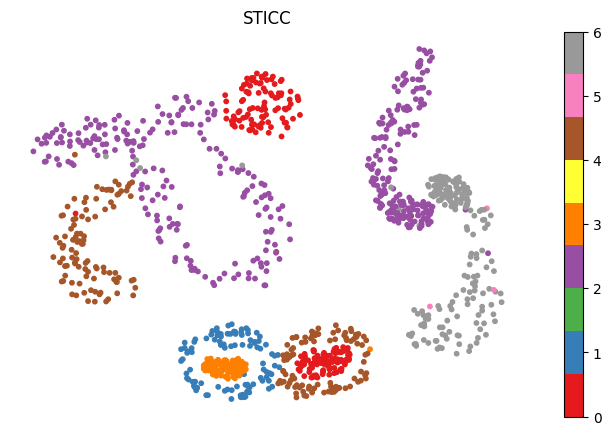

In [177]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

In [175]:
np.random.seed(1234)

# Pyclustering Algorithms for Comparison

## Attribute-based

In [31]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample

In [50]:
def get_pycluster_result(ground_truth, cluster_method, save_fig=False, title="title"):
    data = ground_truth[["attr1", "attr2", "attr3", "attr4", "attr5"]] # For K-Means
#     data = ground_truth[["attr1", "attr2", "attr3", "attr4", "attr5", "x", "y"]]  # For Sp K-Means
    
    scaler = preprocessing.StandardScaler().fit(data.values)
    data = scaler.transform(data.values)
    
    if cluster_method == kmeans:
        initial_centers = kmeans_plusplus_initializer(data, 7).initialize()
        instance = cluster_method(data.tolist(), initial_centers)
    elif cluster_method == cure:
        instance = cluster_method(data, 7)
    else:
        instance = cluster_method(data.tolist(), 7)

    instance.process()
    clusters = instance.get_clusters()
    
    clusters_result = []
    for i, clus in enumerate(clusters):
        for data in clus:
            clusters_result.append([data, i])
    clusters_result_df = pd.DataFrame(clusters_result, columns=["pt", "group"]).sort_values("pt").set_index("pt")
    
    synthetic_data_cluster = ground_truth.join(clusters_result_df)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    markersize = 10
    synthetic_data_cluster.plot(column="group", cmap="Set1", markersize=markersize, legend=True, ax=ax)
    
    ax.set_axis_off()
    ax.title.set_text(f'{title}')
    if save_fig:
        fig.savefig(f'paper/exp1_result/{title}.jpg', dpi=300, bbox_inches='tight')
        
    synthetic_data_cluster.group = synthetic_data_cluster.group.fillna(-1)
    
    print("ARI", adjusted_rand_score(synthetic_data_cluster.group, synthetic_data_cluster.clus_group_gt))
    
    sp_contiguity = cal_joint_statistic(synthetic_data_cluster, w_voronoi)
    print("Spatial contiguity: ", sp_contiguity)
    
    get_max_f1_score(synthetic_data_cluster)

    return synthetic_data_cluster

ARI 0.0009738306588075668
Spatial contiguity:  0.9882150043115838
f1_score  0.052959547168761466 [1, 2, 4, 6, 3, 7, 5]


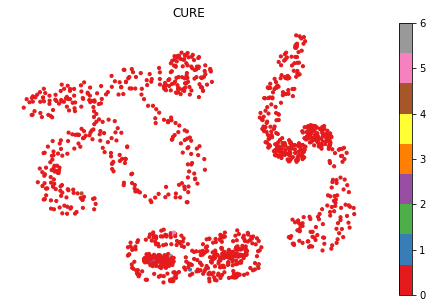

In [51]:
synthetic_data_cure = get_pycluster_result(synthetic_data, cure, False, "CURE")

ARI 0.5368590873785082
Spatial contiguity:  0.5501580914055764
f1_score  0.6353867526903926 [6, 4, 7, 3, 2, 5, 1]


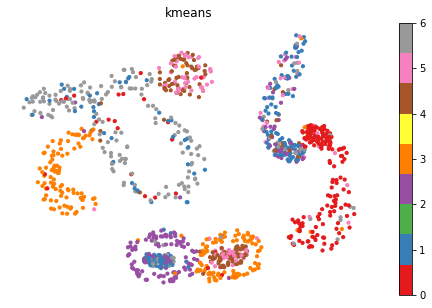

In [52]:
synthetic_data_kmeans = get_pycluster_result(synthetic_data, kmeans, False, "kmeans")

ARI 0.8241512383311884
Spatial contiguity:  0.8766887036504742
f1_score  0.742620245910928 [7, 1, 6, 4, 2, 3, 5]


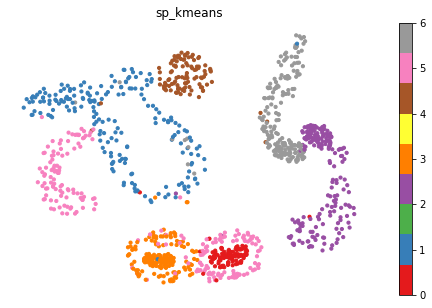

In [35]:
synthetic_data_kmeans = get_pycluster_result(synthetic_data, kmeans, False, "sp_kmeans")

# Density-based

In [36]:
def get_pycluster_result(ground_truth, cluster_method, radius, neighbors, save_fig=False, title="Title"):
    data = ground_truth[["x", "y"]].values
    
    if cluster_method == dbscan:      
        instance = cluster_method(data, radius, neighbors)
    elif cluster_method == cure:
        instance = cluster_method(data, 7)
    else:
        instance = cluster_method(data.tolist(), 7)

    instance.process()
    clusters = instance.get_clusters()
    
    clusters_result = {}
    clusters_result_list = []
    
    for i, clus in enumerate(clusters):
        for data in clus:
            clusters_result[data] = i
    
    for i in range(ground_truth.shape[0]):
        if i in clusters_result.keys():
            clusters_result_list.append([i, clusters_result[i]])
        else:
            clusters_result_list.append([i, -1])
    clusters_result_df = pd.DataFrame(clusters_result_list, columns=["pt", "group"]).sort_values("pt").set_index("pt")
    
    synthetic_data_cluster = ground_truth.join(clusters_result_df)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    markersize = 10
    synthetic_data_cluster.plot(column="group", cmap="Set1", markersize=markersize, legend=True, ax=ax)
    
    ax.set_axis_off()
    if save_fig:
        ax.title.set_text(f'{title}')
        fig.savefig(f'paper/exp1_result/{title}.jpg', dpi=300, bbox_inches='tight')
    
    print("ARI", adjusted_rand_score(synthetic_data_cluster.group, synthetic_data_cluster.clus_group_gt))
    
    sp_contiguity = cal_joint_statistic(synthetic_data_cluster, w_voronoi)
    print("Spatial contiguity: ", sp_contiguity)

    return synthetic_data_cluster

ARI 0.32731248220334885
Spatial contiguity:  0.9410750215579189


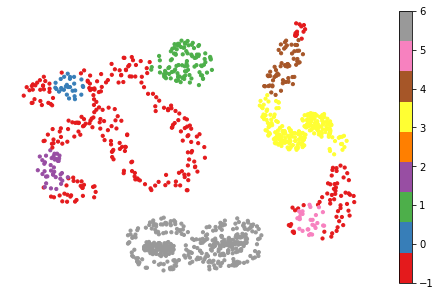

In [37]:
synthetic_data_dbscan = get_pycluster_result(synthetic_data, dbscan, 1250, 25, False, "DBSCAN")

# GMM

In [38]:
gmm_data = synthetic_data.copy()
gmm_data.head(1)

,clus_group,x,y,geometry,clus_group_gt,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
0,1,660.0,15060.0,POINT (660.000 15060.000),1,4.471435,2.15853,96.540978,1016.510958,997.32216,41,78,45


In [39]:
X = gmm_data[["attr1", "attr2", "attr3", "attr4", "attr5"]].values

In [40]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [41]:
gm = GaussianMixture(n_components=7).fit(X)
gmm = pd.DataFrame(gm.predict(X), columns=["group"])
gmm.head(1)

,group
0,3


ARI 0.59594872333268
Spatial contiguity:  0.6335153779821788
f1_score  0.676367617716395 [5, 3, 2, 1, 4, 7, 6]


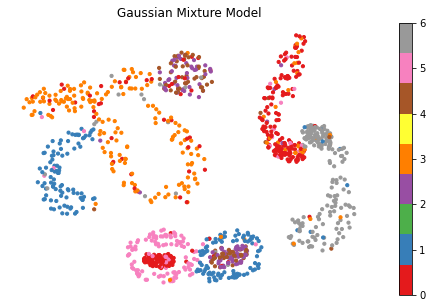

In [42]:
gmm_cluster = gmm_data.join(gmm)

fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
gmm_cluster.plot(column="group", cmap="Set1", markersize=markersize, legend=True, ax=ax)

ax.set_axis_off()
title = "Gaussian Mixture Model"

ax.title.set_text(f'{title}')
print("ARI", adjusted_rand_score(gmm_cluster.group, gmm_cluster.clus_group_gt))

sp_contiguity = cal_joint_statistic(gmm_cluster, w_voronoi)
print("Spatial contiguity: ", sp_contiguity)

get_max_f1_score(gmm_cluster)

# Spatially Constrained Multivariate Clustering using ArcGIS

In [43]:
arcgis_result = gpd.read_file('data/sticc_points_spatial_multivariate.shp')
arcgis_result.head(1)

,SOURCE_ID,synthetic_,syntheti_1,syntheti_2,syntheti_3,syntheti_4,CLUSTER_ID,MEM_PROB,geometry
0,0,4.384146,4.001144,87.435936,853.202725,997.15953,1,0.7,POINT (-9964751.414 5323459.701)


In [44]:
arcgis_result.CLUSTER_ID.unique()

array([1, 2, 5, 3, 4, 6, 7])

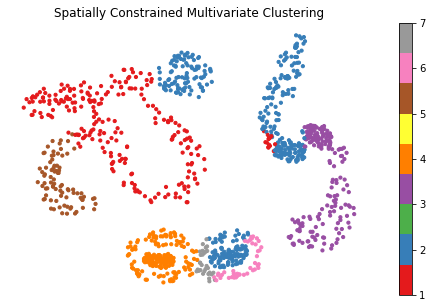

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
synthetic_data_sticc_plot = arcgis_result.copy()
synthetic_data_sticc_plot.plot(column="CLUSTER_ID", cmap="Set1", markersize=markersize, legend=True, ax=ax)
ax.set_axis_off()
ax.title.set_text('Spatially Constrained Multivariate Clustering')

In [46]:
arcgis_data = synthetic_data.copy()
arcgis_data = arcgis_data.reset_index()
arcgis_data.head(1)

,index,clus_group,x,y,geometry,clus_group_gt,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
0,0,1,660.0,15060.0,POINT (660.000 15060.000),1,4.471435,2.15853,96.540978,1016.510958,997.32216,41,78,45


In [47]:
arcgis_cluster = pd.merge(left=arcgis_data, left_on=arcgis_data["index"], 
                          right=arcgis_result[["SOURCE_ID", "CLUSTER_ID"]], 
                          right_on=arcgis_result.SOURCE_ID).rename({"CLUSTER_ID": "group"}, axis=1)
print("ARI", adjusted_rand_score(arcgis_cluster.group, arcgis_cluster.clus_group_gt))

sp_contiguity = cal_joint_statistic(arcgis_cluster, w_voronoi)
print("Spatial contiguity: ", sp_contiguity)

get_max_f1_score(arcgis_cluster)

ARI 0.6290249736978822
Spatial contiguity:  0.935901121011785
f1_score  0.5466289937184365 [5, 1, 2, 6, 4, 3, 7]


# MRF Explanation

In [48]:
def compute_centrality(mrf_G):
    for edge in mrf_G.edges:
        origin = edge[0]
        dest = edge[1]
        mrf_G[origin][dest]['weight'] = mrf[origin][dest]
    centrality_dict = nx.algorithms.centrality.betweenness_centrality(mrf_G, weight="weight")
    return centrality_dict

In [53]:
clus = 7
for cluster in range(clus):
    with open(f'output_folder/MRF_synthetic_data_{cluster}.npy', 'rb') as f:
        mrf = np.load(f)
        mrf_G = nx.from_numpy_matrix(mrf)
        between_centrality = compute_centrality(mrf_G)
        print(cluster, between_centrality)

0 {0: 0.7417582417582418, 1: 0.6868131868131868, 2: 0.4560439560439561, 3: 0.18131868131868134, 4: 0.6043956043956045, 5: 0.7527472527472528, 6: 0.14285714285714288, 7: 0.6923076923076924, 8: 0.24725274725274726, 9: 0.20329670329670332, 10: 0.8131868131868133, 11: 0.6758241758241759, 12: 0.2802197802197802, 13: 0.27472527472527475, 14: 0.7032967032967034}
1 {0: 0.8571428571428572, 1: 0.7967032967032968, 2: 0.1043956043956044, 3: 0.23626373626373628, 4: 0.3241758241758242, 5: 0.9120879120879122, 6: 0.6263736263736264, 7: 0.25824175824175827, 8: 0.19780219780219782, 9: 0.36813186813186816, 10: 0.8846153846153847, 11: 0.7087912087912088, 12: 0.2967032967032967, 13: 0.34065934065934067, 14: 0.554945054945055}
2 {0: 0.8241758241758242, 1: 0.42307692307692313, 2: 0.6263736263736264, 3: 0.06593406593406594, 4: 0.7582417582417583, 5: 0.8846153846153847, 6: 0.48901098901098905, 7: 0.34065934065934067, 8: 0.14835164835164835, 9: 0.5879120879120879, 10: 0.8956043956043956, 11: 0.5164835164835165,

In [268]:
#missglasso = [0.7470, 0.9562, 0.9543, 0.9548, 0.8389]
#meaninterp = [0.9358, 0.9217, 0.8076, 0.7765, 0.7284]
# missglasso = [0.8583, 0.8971, 0.8968, 0.8974, 0.8800]
# meaninterp = [0.8842, 0.8701, 0.8313, 0.8192, 0.7655]
missglasso = [0.7870, 0.9830, 0.9820, 0.9817, 0.8677]
meaninterp = [0.9736, 0.9664, 0.7900, 0.7587, 0.7533]

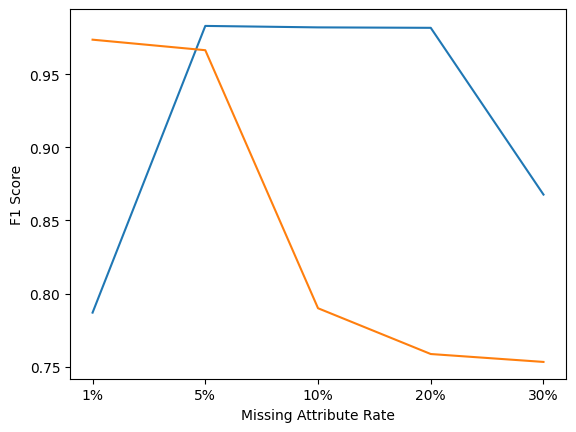

In [270]:
from matplotlib import pyplot as plt

plt.figure()
plt.xlabel('Missing Attribute Rate')
plt.ylabel('F1 Score')
plt.xticks(ticks=(0,1,2,3,4), labels=('1%','5%','10%','20%','30%'))
plt.plot(missglasso)
plt.plot(meaninterp)

In [9]:
!rm -rf result_nyc_checkin_data.txt
!python STICC_main.py --fname=sticc_nyc_checkin.txt --oname=result_nyc_checkin_data.txt --attr_idx_start=1 \
--attr_idx_end=7 --spatial_idx_start=8 --spatial_idx_end=17 \
--spatial_radius=10 --number_of_clusters 10 --lambda_parameter 0.01 --beta 3 --maxIters 20 #--missglasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 10
num stacked 10
completed getting the data
7 (3628, 7) (3628, 10)
Counter({8: 490, 1: 457, 0: 357, 6: 350, 7: 350, 5: 339, 4: 333, 3: 328, 9: 326, 2: 298})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
OPTIMIZATION for Cluster # 7 DONE!!!
OPTIMIZATION for Cluster # 8 DONE!!!
OPTIMIZATION for Cluster # 9 DONE!!!
length of the cluster  0 ------> 357
length of the cluster  1 ------> 457
length of the cluster  2 ------> 298
length of the cluster  3 ------> 328
length of the cluster  4 ------> 333
length of the cluster  5 ------> 339
length of the cluster  6 ------> 350
length of the cluster  7 ------> 350
length of the cluster  8 ------> 490
length of the cluster  9 ------> 326
UPDATED THE OLD COVARIANCE
beginning

OPTIMIZATION for Cluster # 8 DONE!!!
OPTIMIZATION for Cluster # 9 DONE!!!
length of the cluster  0 ------> 111
length of the cluster  1 ------> 272
length of the cluster  2 ------> 675
length of the cluster  3 ------> 133
length of the cluster  4 ------> 688
length of the cluster  5 ------> 646
length of the cluster  6 ------> 346
length of the cluster  7 ------> 129
length of the cluster  8 ------> 470
length of the cluster  9 ------> 158
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[-125.0783 -141.0007 -134.8945 ... -131.0419 -131.3562 -133.0647]
 [-138.1964 -138.8480 -140.5231 ... -136.9891 -138.1009 -139.6739]
 [-142.0402 -150.6999 -146.9294 ... -142.8736 -145.4928 -148.2717]
 ...
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 183
length of cluster # 1 --------> 1107
length of cluster # 2 --------> 239
length of cluster # 3 --------

[[-130.5338 -136.7209 -134.5519 ... -124.8095 -130.3443 -131.8627]
 [-138.8165 -140.5872 -138.0160 ... -136.4784 -138.2642 -137.8160]
 [-143.6682 -148.3836 -148.4670 ... -141.4307 -143.6539 -145.4765]
 ...
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 861
length of cluster # 1 --------> 726
length of cluster # 2 --------> 603
length of cluster # 3 --------> 184
length of cluster # 4 --------> 230
length of cluster # 5 --------> 167
length of cluster # 6 --------> 211
length of cluster # 7 --------> 342
length of cluster # 8 --------> 130
length of cluster # 9 --------> 174







ITERATION ### 11
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
OPT

length of cluster # 5 --------> 184
length of cluster # 6 --------> 561
length of cluster # 7 --------> 82
length of cluster # 8 --------> 295
length of cluster # 9 --------> 677







ITERATION ### 16
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
OPTIMIZATION for Cluster # 7 DONE!!!
OPTIMIZATION for Cluster # 8 DONE!!!
OPTIMIZATION for Cluster # 9 DONE!!!
length of the cluster  0 ------> 284
length of the cluster  1 ------> 364
length of the cluster  2 ------> 405
length of the cluster  3 ------> 166
length of the cluster  4 ------> 610
length of the cluster  5 ------> 184
length of the cluster  6 ------> 561
length of the cluster  7 ------> 82
length of the cluster  8 ------> 295
length of the cluster  9 ------> 677
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGOR